#### Case 2: Isobaric evaporation of liquid nitrogen in a 6.75 L vertically orientated cylindrical tank experiments.

This notebook sets up the isobaric evaporation of liquid nitrogen ($LN_2$) in a 6.75 L storage tank. A low liquid filling, low heat ingress scenario from Seo and Jeong (2009) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties

In [2]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 0.201 # Internal diameter / m
d_o = 0.204   # External diameter / m
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.026 # W/m2/K
U_V = 0.026 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 6.75e-3 #m^3

# Initial liquid filling / Dimensionless
LF = 0.278 

# Specify tank operating pressure
P = 100000 # Pa

# Initialize large-scale tank
small_tank = Tank(d_i, d_o, V_tank, LF)
small_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.963)

# Initialise cryogen
nitrogen = Cryogen(name = "nitrogen")
nitrogen.set_coolprops(P)

# Set cryogen
small_tank.cryogen = nitrogen

# Calculate initial evaporation rate
print("The initial evaporation rate of " + nitrogen.name + " is %.1e kg/h" % (small_tank.b_l_dot * 3600))

The initial evaporation rate of nitrogen is 1.4e-02 kg/h


Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + nitrogen.name + " is %.1e kg/h" % (small_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % small_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(small_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (small_tank.b_l_dot * 24 * 3600) / (small_tank.V * small_tank.LF * small_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of nitrogen is 1.4e-02 kg/h
Transient period = 5807.599 s 
Simulation time: 2 h
BOR = 21.827 %


#### Simulation setup and execution

In [14]:
# Define vertical spacing
dz = 0.005

# Calculate number of nodes
n_z = 1 + int(np.round(small_tank.l_V/dz, 0))

# Define dimensionless computational grid
small_tank.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
small_tank.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 3600 * tau_h * 2

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
small_tank.time_interval = 60

# Time step to plot each vapour temperature profile
small_tank.plot_interval = evap_time/6

# Simulate the evaporation
small_tank.evaporate(evap_time)

#### Visualisation of results

#### Vapour temperature

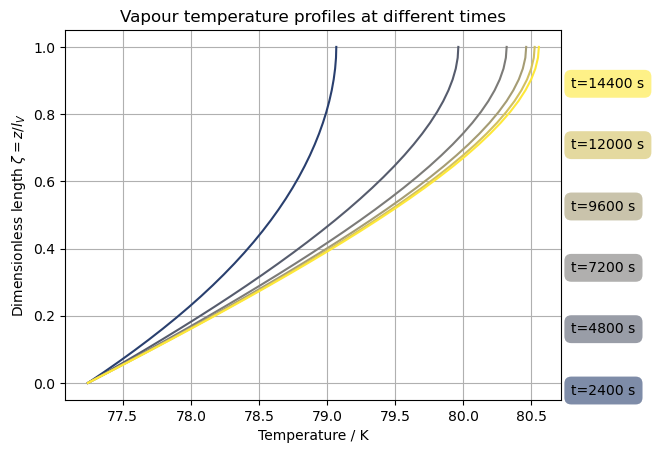

In [15]:
# Visualise the plot
small_tank.plot_tv()

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

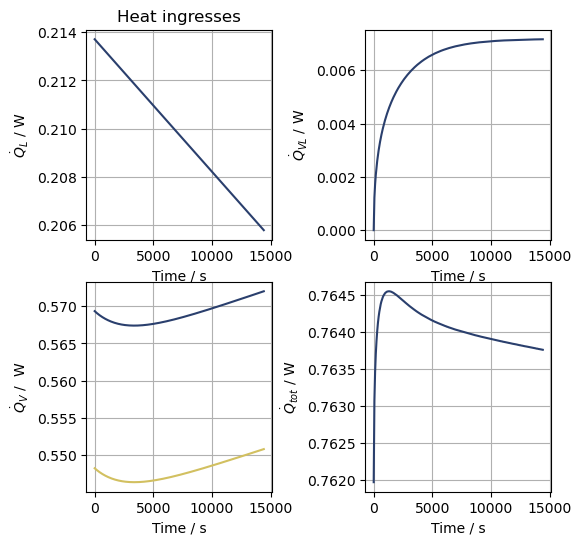

In [16]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_Q(unit="W")

#### Plot liquid volume

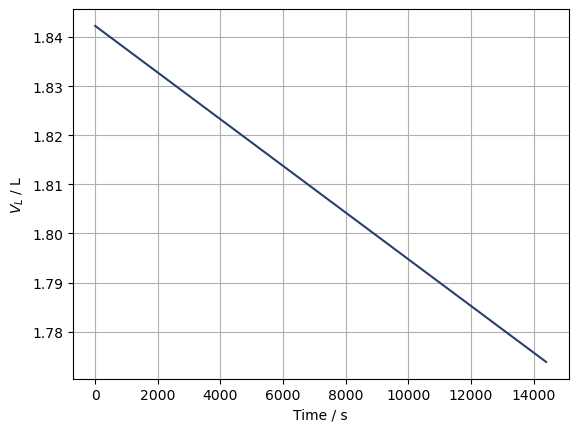

In [17]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_V_L(unit="L")

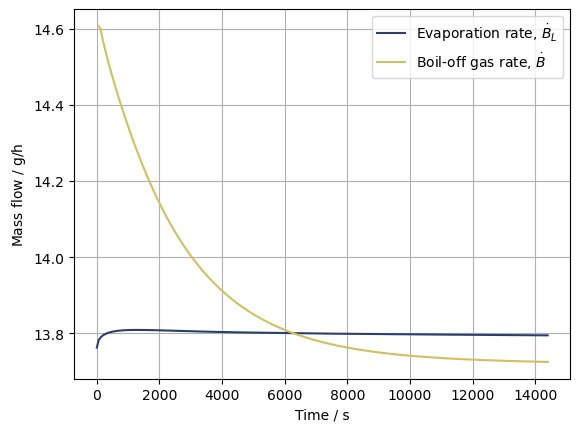

In [18]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_BOG(unit='g/h')

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [19]:
# Import pandas 
import pandas as pd

In [20]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank.data)

# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

# Show the first five columns of the dataframe in console
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,Q_Vw
0,0.0,77.243500,4.556334,0.000000,0.213714,0.569326,0.001842,0.000004,0.000004,0.000000,0.000000e+00,0.548261
1,60.0,77.291351,4.553268,0.001220,0.213681,0.569236,0.001842,0.000004,0.000004,-0.000051,-4.745653e-09,0.548174
2,120.0,77.337097,4.550202,0.001721,0.213648,0.569151,0.001842,0.000004,0.000004,-0.000050,-4.748585e-09,0.548092
3,180.0,77.381359,4.547240,0.002078,0.213614,0.569070,0.001841,0.000004,0.000004,-0.000049,-4.750175e-09,0.548014
4,240.0,77.424363,4.544367,0.002361,0.213581,0.568992,0.001841,0.000004,0.000004,-0.000047,-4.751306e-09,0.547939


The curved shape of the temperature profile is a consequence of the low Péclet number at this scale:

In [21]:
alpha_V = (small_tank.cryogen.k_V_avg /
           (small_tank.cryogen.rho_V_avg * small_tank.cryogen.cp_V_avg))

Pe = small_tank.v_z * small_tank.l_V/alpha_V
print("Pe = %.3f" % Pe)

Pe = 2.756


As $\text{Pe} \approx 1$, both advection and thermal conduction occur at a similar rate and none can be neglected.

We also calculate the relative dominance of the wall heating source terms through the dimensionless parameters

$$\Pi_1 = \frac{S l^2}{\alpha}; \Pi_2 = \frac{Sl}{\bar{v}_z} $$

Where 
$$ S = \frac{4U_V d_o}{\rho_V \hat{c}_p d_i^2} \times \frac{l_0^2}{\alpha} $$

In [22]:
Pi_1 = 4 * small_tank.U_V * small_tank.d_o / (small_tank.d_i**2 *
                                      small_tank.cryogen.rho_V_avg * 
                                      small_tank.cryogen.cp_V_avg *
                                      alpha_V) * small_tank.l_V**2
Pi_2 = Pi_1/Pe
print("Pi_1 = %.3f" % Pi_1)
print("Pi_2 = %.3f" % Pi_2)

Pi_1 = 1.752
Pi_2 = 0.636


#### References



In [23]:
print("Final liquid volume over initial liquid volume")
df_evap['V_L'].values[-1]/df_evap['V_L'].values[0]

Final liquid volume over initial liquid volume


0.9628520394713426


M. Seo, S. Jeong, Analysis of self-pressurization phenomenon of cryogenic fluid storage tank with thermal diffusion model, Cryogenics, 50(9) (2010) 549-555.